In [ ]:
# default_exp convolution

# Convolution

# Task 3: Convolution
> Mathematically, applying a Gaussian blur to an image is the same as convolving the image with a Gaussian function. 

Implementujte výpočet konvoluce s Gaussovským jádrem s volitelným rozptylem. Pro zrychlení výpočtu použijte metodu separabilní konvoluce. Aplikujte konvoluci na vstupní obraz s několika různými rozptyly jádra a výsledek uložte do souboru.

In [ ]:
# export
import numpy as np

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

from dzotools.utils import imgload
from dzotools.fourier import draw_pair

lena = imgload('data/lenna.png', convert="L")
fractal = imgload('data/fractal.png', convert="L")
square = imgload('data/square.png', convert="L")
wave = imgload('data/wave.png', convert="L")

### 1D Kernel implementation
Kernel that works on 1D input. Since the gaussian kernel is linearly separable, we can split the 2D kernel into two 1D kernels. We apply them separately to speed up the computation.

The process is supposed to work like this:
1. apply the kernel over rows
2. apply the kernel over previous output (over columns now)

In [ ]:
# exports
def gauss1D(sigma: float, bounds: tuple = (-3, 3)) -> np.array:
    """Get normalized kernel bounded by sigma values."""
    domain = np.arange(bounds[0]*sigma, bounds[1]*sigma + 1)
    kernel = np.exp(-(domain - 0.0)**2 / (2 * sigma**2))
    return kernel / np.sum(kernel)

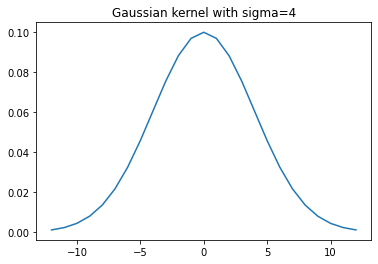

In [ ]:
sigma = 4
gaussian = gauss1D(sigma)
domain = np.arange(len(gaussian)) - len(gaussian) // 2

fig, ax = plt.subplots()
ax.set_title(f"Gaussian kernel with sigma={sigma}")
plt.plot(domain, gaussian)
plt.show()

### 1D Convolution implementation
Apply a filter along the given row/column of the given 2D image.

In [ ]:
# exports
def conv1D(row: np.array, cfilter: np.array, pad="edge") -> np.array:
    """
    Do a 1D convolution of a given filter over the input array. 
    
    Edges are padded with pad strategy, input and output size match.
    Param `pad` controls padding. Eg. `constant` or `edge`.
    """
    
    # halfwidth not including the center <hw, c, hw>
    hw = len(cfilter) // 2
    
    # When hw is 2, we get padded array (0, 0, a, a, a, 0, 0)
    padded = np.pad(row, pad_width=(hw, hw), mode=pad)
    result = np.zeros_like(padded)
        
    for c in range(hw, len(row) + hw):
        result[c] = np.dot(padded[c-hw: c+hw+1], cfilter)
    
    return result[hw:len(row)+hw]

In [ ]:
# Simple test case that filter works as expected
np.testing.assert_equal(
    conv1D(np.array([1, 1, 1, 1, 1]), np.array([1, 1, 1]), "constant"),
    np.array([2, 3, 3, 3, 2])
)

In [ ]:
# Test that the filter of size 1 works as well
np.testing.assert_equal(
    conv1D(np.array([1, 1, 1]), np.array([1]), "constant"),
    np.array([1, 1, 1])
)

Example of 1D gaussian filter applied over rows and columns

In [ ]:
kernel = gauss1D(10)
result = np.zeros_like(lena)

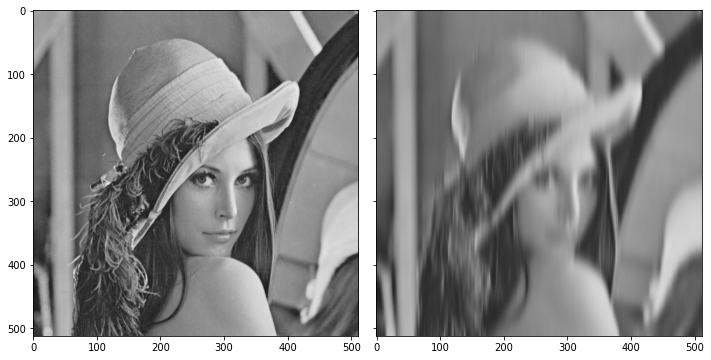

In [ ]:
# Iterate over each column position
for x in range(lena.shape[0]):
    result[:, x] = conv1D(lena[:, x], kernel, "edge")

draw_pair(lena, result)
plt.show()

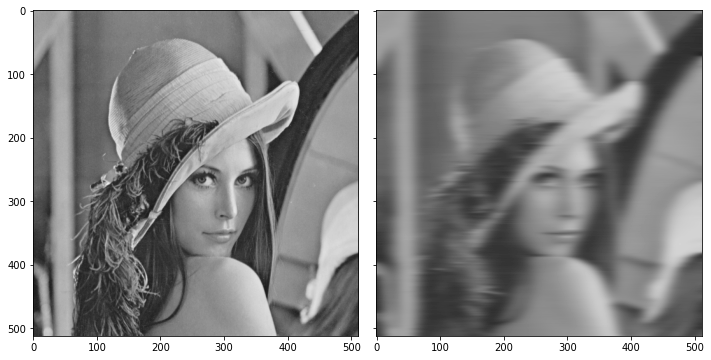

In [ ]:
# Iterate over each row position
for y in range(lena.shape[1]):
    result[y, :] = conv1D(lena[y, :], kernel, "edge")
    
draw_pair(lena, result)
plt.show()

### Putting it all together: 2D Gaussian blur
Putting it all together - apply the 1D filter separately over each dimension to obtain 2D gaussian blur.

In [ ]:
# exports
def separable_blur(arr: np.array, sigma: float, pad="edge") -> np.array:
    """
    Apply the gaussian blur by separable gaussian convolutions over 2D input.
    Note that this method currently only supports B/W (2 channel) inputs.
    """
    
    kernel = gauss1D(sigma)
    result = np.zeros_like(arr)

    for x in range(arr.shape[0]): # columns
        result[:, x] = conv1D(arr[:, x], kernel, pad)
    for y in range(arr.shape[1]): # rows
        result[y, :] = conv1D(result[y, :], kernel, pad)

    return result

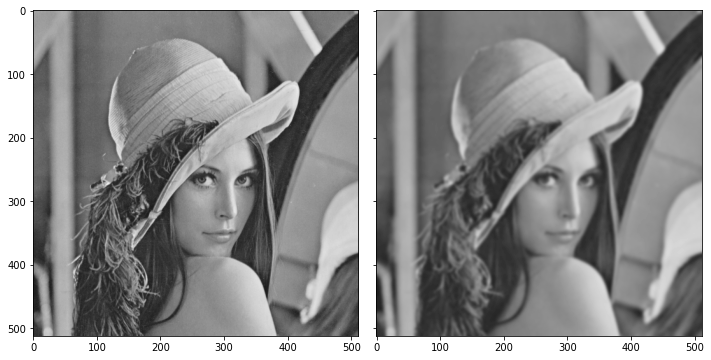

In [ ]:
draw_pair(lena, separable_blur(lena, 2))
plt.show()

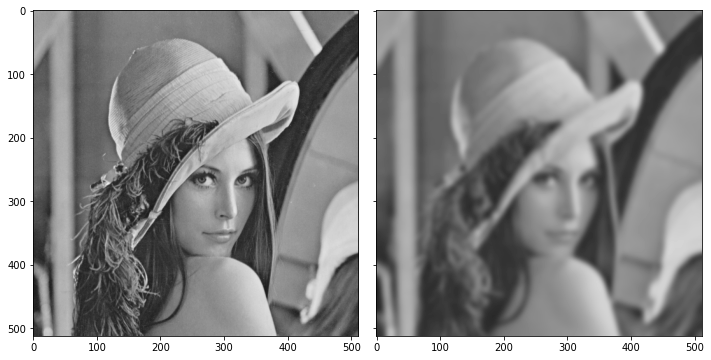

In [ ]:
draw_pair(lena, separable_blur(lena, 4))
plt.show()

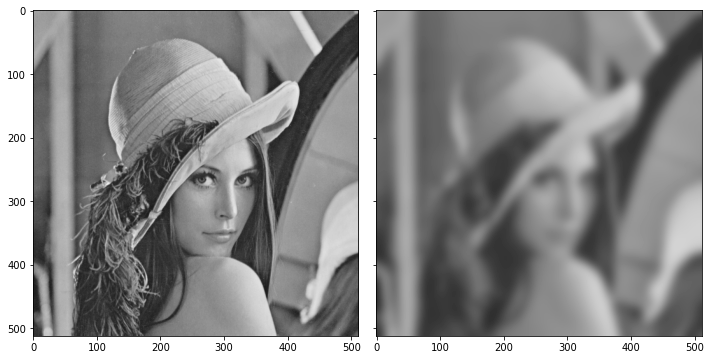

In [ ]:
draw_pair(lena, separable_blur(lena, 8))
plt.show()

Check that the predicted output matches the output of scipy library as a sanity check.

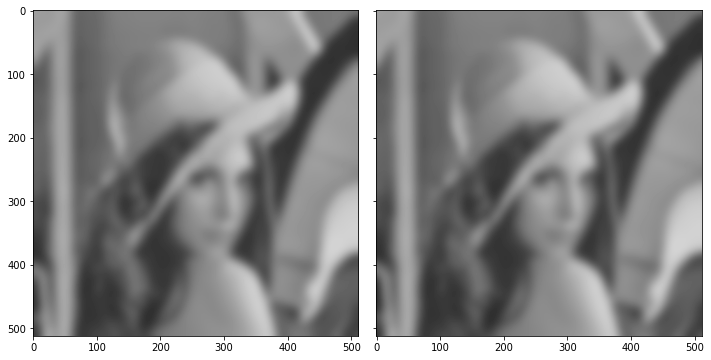

In [ ]:
from scipy.ndimage import gaussian_filter

scipy_result = gaussian_filter(lena, 8)
implemented = separable_blur(lena, 8)

draw_pair(scipy_result, implemented)
plt.show()

### Example outputs on different images

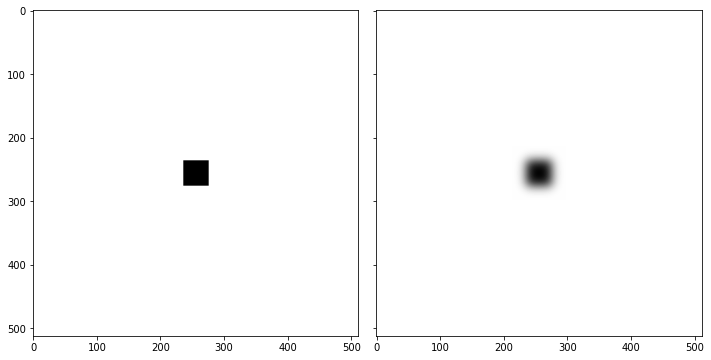

In [ ]:
draw_pair(square, separable_blur(square, 8))
plt.show()

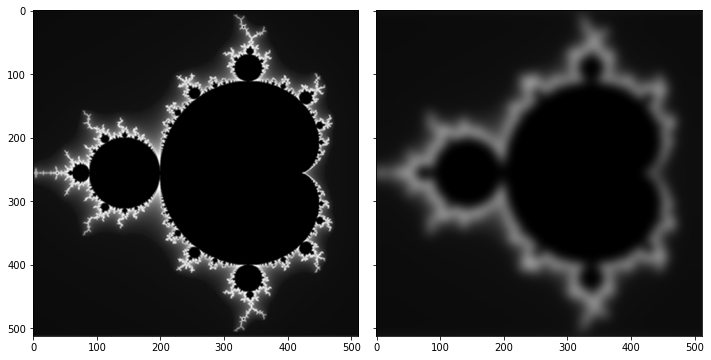

In [ ]:
draw_pair(fractal, separable_blur(fractal, 8))
plt.show()

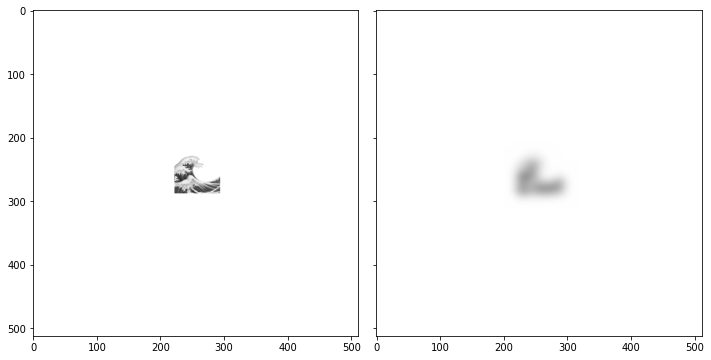

In [ ]:
draw_pair(wave, separable_blur(wave, 8))
plt.show()

### How much faster is it?
But how much faster is the separable kernel compared to a 2D conv?

In [ ]:
# exports
def gauss2D(sigma: float, bounds: tuple = (-3, 3)) -> np.array:
    """Get normalized 2D gauss kernel bounded by sigma values."""
    domain = np.arange(bounds[0]*sigma, bounds[1]*sigma + 1)
    dom_x, dom_y = np.meshgrid(domain, domain)
    kernel = np.exp(-(dom_x**2 + dom_y**2) / (2 * sigma**2))
    return kernel / np.sum(kernel)

In [ ]:
# exports
def conv2D(arr: np.array, cfilter: np.array, pad="edge") -> np.array:
    """Do a 2D convolution of a given filter over the input array."""
    
    # Assume that the filter is symmetrical.
    assert cfilter.shape[0] == cfilter.shape[1]
    
    # halfwidth not including the center <hw, c, hw>
    hw = cfilter.shape[0] // 2
    
    # When hw is 2, we get padded array (0, 0, a, a, a, 0, 0)
    padded = np.pad(arr, pad_width=(hw, hw), mode=pad)
    result = np.zeros_like(padded)        
    
    for x in range(hw, arr.shape[0] + hw):
        for y in range(hw, arr.shape[1] + hw):
            # Sum the element-wise product of matrix multiplication
            result[x, y] = np.sum(padded[x-hw: x+hw+1, y-hw: y+hw+1] * cfilter)
    
    return result[hw:arr.shape[0] + hw, hw:arr.shape[1] + hw]

In [ ]:
def naive_blur(arr: np.array, sigma: float, pad="edge") -> np.array:
    """Blur the image by simply applying the 2D filter as 2D convolution."""
    filter2D = gauss2D(sigma)
    return conv2D(arr, filter2D, pad)

### Compare the results

The table below shows the comparation of runtime for naive gaussian blur (convolutions of 2D gaussian filters over image) compared to a kernel separable method.

| kernel size | naive            | separable   |
|--------|------------------|------------------|
| 5      | 2.91 s ± 60.8 ms | 1.28 s ± 16.0 ms |
| 10     | 4.35 s ± 251. ms | 1.33 s ± 42.1 ms |
| 15     | 7.10 s ± 201. ms | 1.32 s ± 16.3 ms |
| 30     | 17.0 s ± 476. ms | 1.45 s ± 24.4 ms |

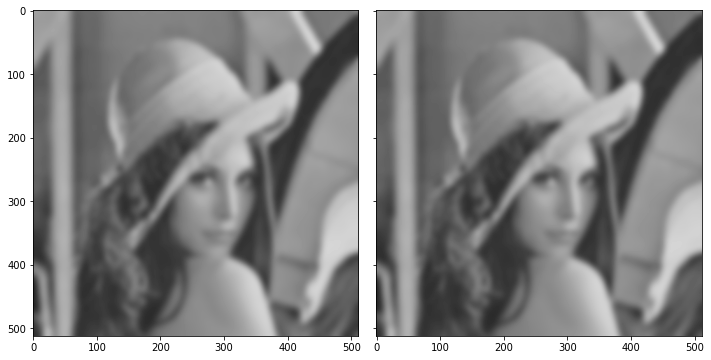

In [ ]:
naive = naive_blur(lena, 5)
separable = separable_blur(lena, 5)

draw_pair(naive, separable)
plt.show()